## Plot graphs for the report - Analysis of a big grid search

In [161]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
plt.style.use('seaborn-v0_8-ticks')
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 13})
import pandas as pd
import os

sts = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]  # 16
ratios = [[1000,1],[100,1],[10,1],[1,1],[1,10],[1,100],[1,1000]]    #7
sizes = [5,10,15,20,25,30,35,40,45,50]  #10

In [162]:
# Import all individual data points
path = "data/run_analysis/"
files = os.listdir(path)
out = []
for file in files:
    if "result_CRAM_" in file and "IC" not in file:
        out.append(np.load(path+file, allow_pickle=True))
out = np.array(out)
out_ = out.T

In [163]:
# Preprocessing
weights_0, weights_1, ratio, st, stiffness, n_max, pinn_time, time_cram, epochs, total_error, final_error, relative_error, relative_final_error = out_[:13]
loss_history, IC_loss_history, ODE_loss_history = out_[13:13+51], out_[13+51:13+2*51], out_[13+2*51:]
IC_loss = np.array([np.trim_zeros(IC_loss_history[:,i], "b")[-1] for i in range(len(epochs))])
ODE_loss = np.array([np.trim_zeros(ODE_loss_history[:,i], "b")[-1] for i in range(len(epochs))])
loss = np.array([np.trim_zeros(loss_history[:,i], "b")[-1] for i in range(len(epochs))])

In [164]:
# Save data
df = pd.DataFrame(np.array([*out_[:13], loss, IC_loss, ODE_loss]).T)
df.to_csv("run_analysis_data.csv", index=False)

In [165]:
def create_mask_array(A, B, C):
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    unique_combinations = np.column_stack((A, B))
    unique_combinations = unique_combinations.astype(np.int32)
    unique_combinations = np.unique(unique_combinations, axis=0)
    # Create an empty mask array with the same shape as A[2]
    mask = np.zeros_like(C, dtype=int)
    # Iterate over each unique combination
    for combination in unique_combinations:
        # Find the minimum value of A[2] for the current combination
        min_value = np.min(C[(A == combination[0]) * (B == combination[1])])
        # Set the positions of the minimum value in the mask array
        mask[(C == min_value)*(A==combination[0])*(B == combination[1])] = 1
    mask = mask.astype(bool)
    return mask

mask_best = create_mask_array(st, n_max, relative_final_error)

### Vary stiffness

Write a paragraph describing two graphs and mention the following results:

The performance of the model is heavily dependent on the stiffness of matrix A. 
Isn't impacted at lower stiffnesses.
There is a cutoff where the relative error jumps to 1, which happens at stiffness around 10^20. We presume this is due to the numerical limits of the variables used.

The stiffness does not affect the computation time of CRAM, which is similar for PINN when the stiffness is below the cutoff value.

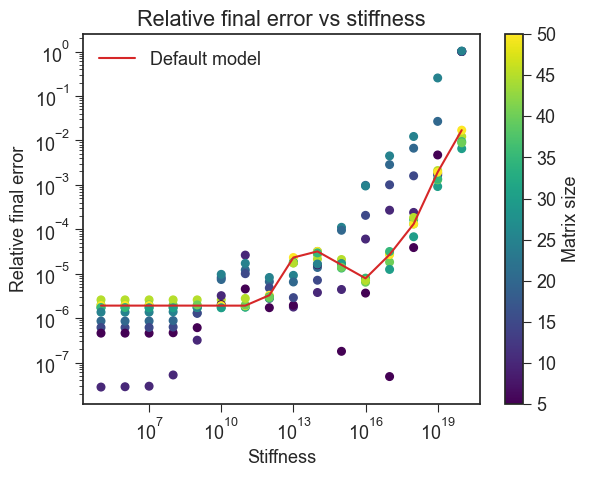

In [166]:
plt.scatter(stiffness[mask_best], relative_final_error[mask_best], s = 30, c=n_max[mask_best], cmap="viridis")
xs, ys = zip(*sorted(zip(stiffness[mask_best * (n_max==50)], relative_final_error[mask_best * (n_max==50)])))
plt.plot(xs, ys, label="Default model", c=colors[3])
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylabel("Relative final error")
plt.xlabel("Stiffness")
plt.title("Relative final error vs stiffness")
plt.colorbar(label="Matrix size")
plt.savefig("results/final/error_vs_stiffness_multi.png", bbox_inches='tight')

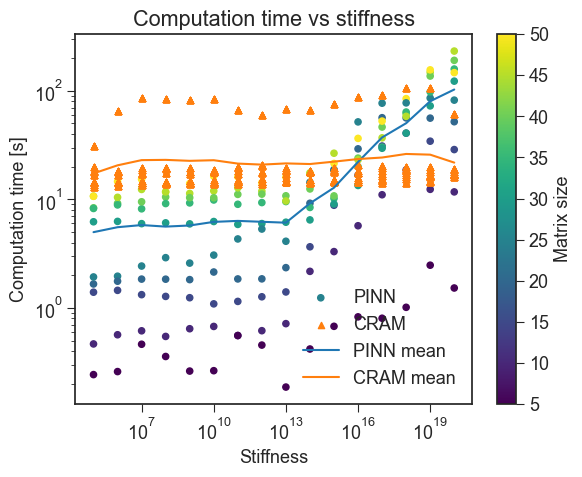

In [177]:
plt.scatter(stiffness[mask_best], pinn_time[mask_best], s=20, c=n_max[mask_best], cmap="viridis", label="PINN")
plt.colorbar(label="Matrix size")
plt.scatter(stiffness, time_cram, marker="^", c=colors[1], label="CRAM", s=20)
p_time, c_time = [], []
for s in sts:
    mask = st == s
    p_time.append(pinn_time[mask_best * mask].mean())
    c_time.append(time_cram[mask_best * mask].mean())
plt.plot(10.0**np.array(sts), p_time, c=colors[0], label="PINN mean")
plt.plot(10.0**np.array(sts), c_time, c=colors[1], label="CRAM mean")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Computation time [s]")
plt.xlabel("Stiffness")
plt.title("Computation time vs stiffness")
plt.legend()
plt.savefig("results/final/time_vs_stiffness_multi.png", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


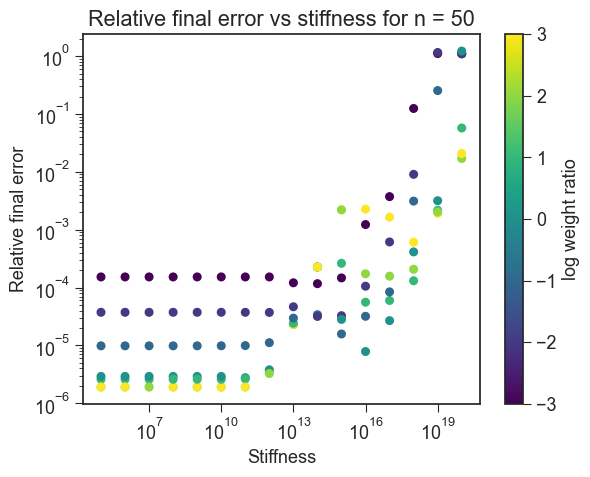

In [168]:
mask = (n_max == 50)
plt.scatter(stiffness[mask], relative_final_error[mask], s=30, c=np.log10(np.array(ratio[mask], dtype=float)), cmap="viridis")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Stiffness")
plt.ylabel("Relative final error")
plt.title("Relative final error vs stiffness for n = 50")
plt.legend()
plt.colorbar(label="log weight ratio")
plt.savefig("results/final/error_vs_stiffness_multi_ratio.png", bbox_inches='tight')

### Vary matrix size

The performance is largely invariant for different matrix sizes, but by increasing the size we do prolong the computation time.

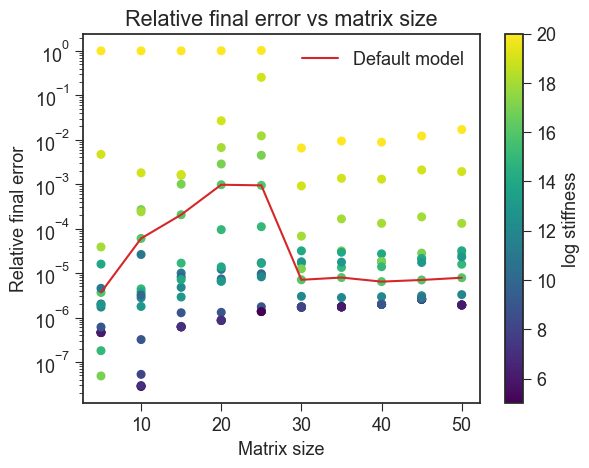

In [169]:
plt.scatter(n_max[mask_best], relative_final_error[mask_best], s=30, c=st[mask_best], cmap="viridis")
xs, ys = zip(*sorted(zip(n_max[mask_best * (st==16)], relative_final_error[mask_best * (st==16)])))
plt.plot(xs, ys, label="Default model", c=colors[3])
plt.colorbar(label="log stiffness")
plt.yscale("log")
plt.legend()
plt.ylabel("Relative final error")
plt.xlabel("Matrix size")
plt.title("Relative final error vs matrix size")
plt.savefig("results/final/error_vs_size_multi.png", bbox_inches='tight')

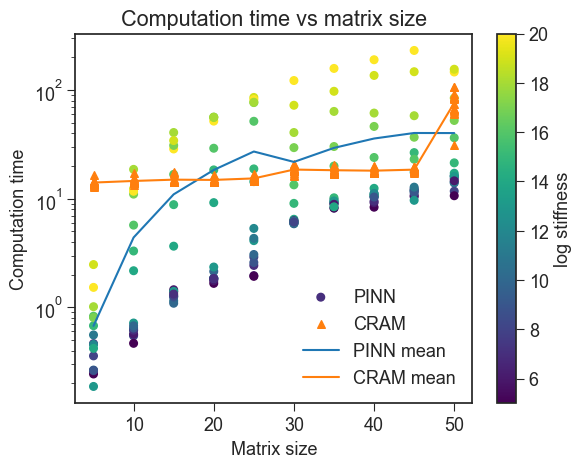

In [176]:
plt.scatter(n_max[mask_best], pinn_time[mask_best], s=30, c=st[mask_best], label="PINN", cmap="viridis")
plt.colorbar(label="log stiffness")
plt.scatter(n_max[mask_best], time_cram[mask_best], s=30, marker="^", c=colors[1], label="CRAM")
p_time, c_time = [], []
for n in sizes:
    mask = n_max == n
    p_time.append(pinn_time[mask * mask_best].mean())
    c_time.append(time_cram[mask * mask_best].mean())
plt.plot(sizes, p_time, c=colors[0], label="PINN mean")
plt.plot(sizes, c_time, c=colors[1], label="CRAM mean")
plt.yscale("log")
plt.ylabel("Computation time")
plt.title("Computation time vs matrix size")
plt.xlabel("Matrix size")
plt.legend()
plt.savefig("results/final/time_vs_size_multi.png", bbox_inches='tight')

### Vary all

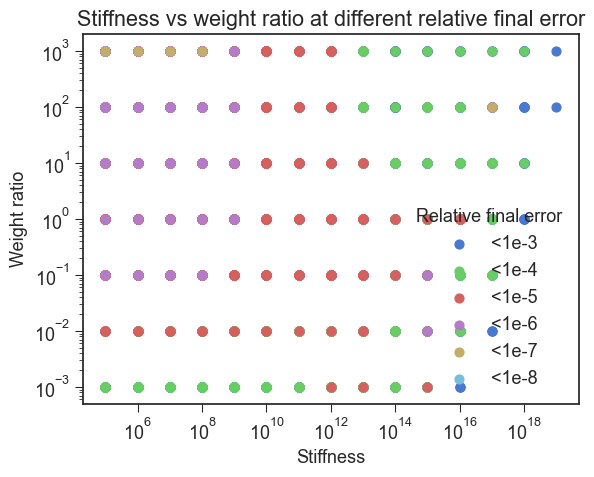

In [171]:
for i in range(3,9):
    plt.scatter(stiffness[relative_final_error < 10**(-i)],ratio[relative_final_error < 10**(-i)], s=40, label=f"<1e-{i}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Stiffness")
plt.ylabel("Weight ratio")
plt.legend(title="Relative final error")
plt.title("Stiffness vs weight ratio at different relative final error")
plt.savefig("results/final/stiffness_vs_weight_at_dif_error.png")
# appendix

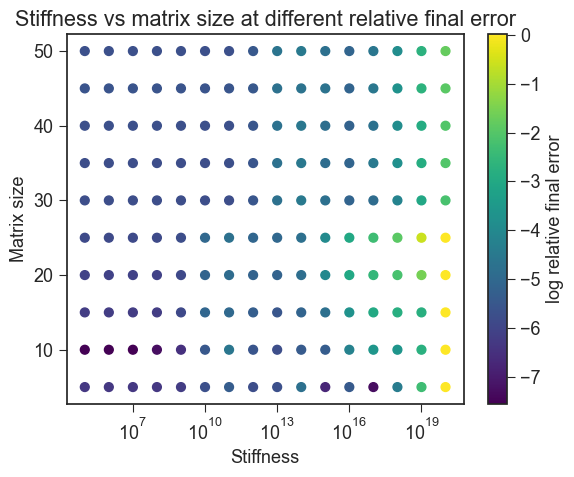

In [172]:
plt.scatter(stiffness[mask_best], n_max[mask_best], c=np.log10(np.array(relative_final_error[mask_best], dtype=float)), s=40, cmap="viridis")
# plt.scatter(stiffness[mask_best], n_max[mask_best], c=np.log10(np.array(relative_final_error[mask_best], dtype=float)), s=250, marker="s", cmap="viridis")
plt.xscale("log")
plt.xlabel("Stiffness")
plt.ylabel("Matrix size")
plt.colorbar(label="log relative final error")
plt.title("Stiffness vs matrix size at different relative final error")
plt.savefig("results/final/stiffness_vs_size_at_dif_error.png")

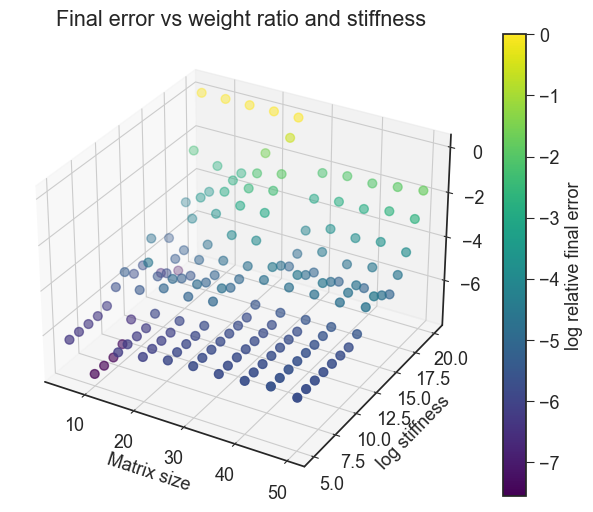

In [173]:
# Weight ratio vs stiffness color is final loss/final error @ particular weight ratio

# Create a figure and a 3D axis
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
log_ratio = [np.log10(r) for r in ratio]
log_final_error = [np.log10(e) for e in final_error]
b = np.log10(np.array(relative_final_error[mask_best], dtype=float))
p = ax.scatter(n_max[mask_best], st[mask_best], b, c=b, cmap="viridis", s=40)
# Set labels and title
ax.set_xlabel('Matrix size')
ax.set_ylabel('log stiffness')
# ax.set_zlabel('log relative final error')
ax.set_title('Final error vs weight ratio and stiffness')
fig.colorbar(p, ax=ax, label='log relative final error')


# Useless graphs

In [174]:
def convert_to(x,y,z):
    x_ = np.unique(x)
    y_ = np.unique(y)
    X, Y = np.meshgrid(x_, y_)
    Z = np.zeros_like(X)
    print(Z.shape, x_.shape, y_.shape)
    z = np.array(z)
    for m, i in enumerate(x_):
        for n, j in enumerate(y_):
            mask = (x == i)*(y == j)
            Z[n,m] = z[mask].mean()
    return X, Y, Z

(16, 7) (7,) (16,)
3.0 20 2.017212376743578


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

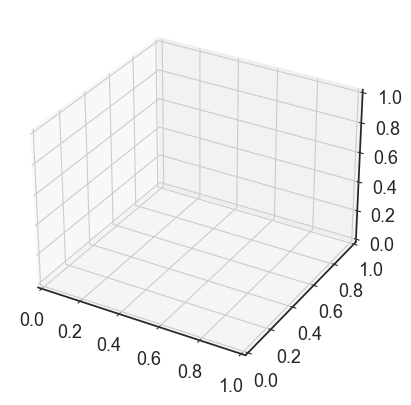

In [175]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid from x and y values
X, Y, Z = convert_to(log_ratio, st, log_final_error)
print(X.max(), Y.max(),Z.max())


# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot')

# Add a colorbar
fig.colorbar(surf)

In [ ]:
plt.plot(IC_loss, final_error, ".", label="IC loss")
plt.plot(ODE_loss, final_error, ".", label = "ODE loss")
plt.plot(loss, final_error, ".", label = "Total loss")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Final error")
plt.xlabel("Loss")
plt.title("IC and ODE loss vs stiffness")
plt.legend()

In [ ]:
ic_epoch = np.array([np.trim_zeros(IC_loss_history[:,i], "b")[-1] for i in range(len(epochs))])
ode_epoch = np.array([np.trim_zeros(ODE_loss_history[:,i], "b")[-1] for i in range(len(epochs))])
loss_epoch = np.array([np.trim_zeros(loss_history[:,i], "b")[-1] for i in range(len(epochs))])
plt.plot(epochs, ic_epoch, ".", c=colors[0], label = "IC loss")
plt.plot(epochs, ode_epoch, ".", c=colors[1],label = "ODE loss")
plt.plot(epochs, loss_epoch, ".", c=colors[2],label = "Total loss")
ic_e, ode_e, loss_e = [], [], []
for e in range(int(epochs.min()), int(epochs.max())+1):
    mask = epochs == e
    # print(ic_epoch[mask].mean())

    ic_e.append(ic_epoch[mask].mean());
    ode_e.append(ode_epoch[mask].mean());
    loss_e.append(loss_epoch[mask].mean());
eps = [i for i in range(int(epochs.min()), int(epochs.max())+1)]
plt.plot(eps, ic_e, c=colors[0], label="IC loss mean")
plt.plot(eps, ode_e, c=colors[1], label="ODE loss mean")
plt.plot(eps, loss_e, c=colors[2], label="Total loss mean")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Epochs vs loss")
plt.legend()

In [ ]:
PATH = "/Users/mihapompe/Documents/Projects/PINNs/miha-semester/data/A_matrices/"
lamda_matrix = load_npz(PATH+"endfb68.npz").toarray()
print(lamda_matrix.shape)
lamda_matrix = remove_zeros(lamda_matrix)
lamda_matrix = permute_matrix(lamda_matrix)
lamda_matrix = fluctuate_equal_eigenvalues(lamda_matrix)

(1624, 1624)
Permuting matrix


In [ ]:
lamda_matrix.shape

(979, 979)

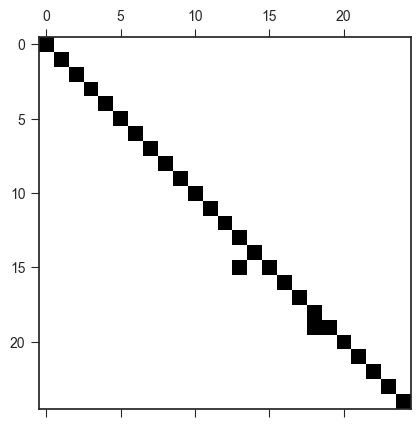

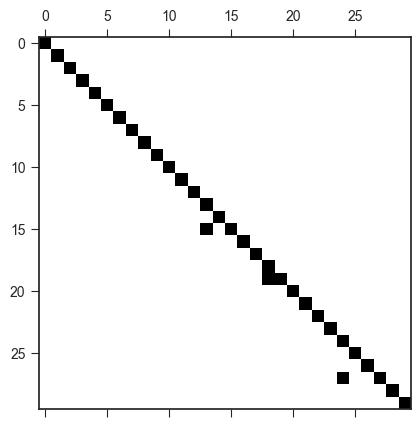

In [ ]:
n = 25
plt.matshow(lamda_matrix[:n,:n] != 0)
n = 30
plt.matshow(lamda_matrix[:n,:n] != 0)

In [ ]:
import numpy as np
PATH = "/Users/mihapompe/Documents/Projects/PINNs/miha-semester/data/A_matrices/"
with open(PATH+"medium_burnup_matrix/reduced_n0.txt", "r") as file:
    # Read all lines and convert them to floats
    lines = file.readlines()
    numbers = [float(line.strip()) for line in lines]
# Convert the list to a NumPy array
initial = np.array(numbers)

In [ ]:
initial.shape

(442,)

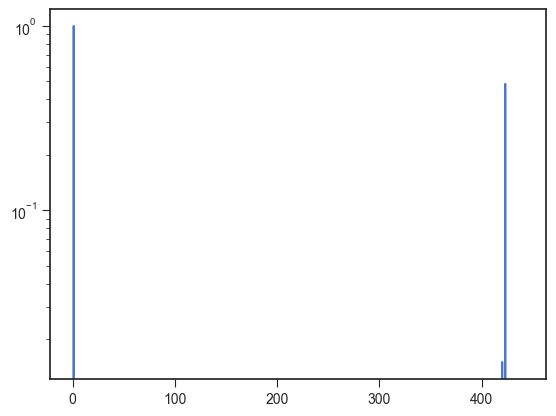

In [ ]:
initial[initial < 1e15] = 0
initial /= np.max(initial)
plt.plot(initial)
plt.yscale("log")

In [ ]:
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
from Bateman_PINN import *
# mat = load_npz("data/A_matrices/endfb80.npz").toarray()
mat = load_npz("data/A_matrices/large_matrices/burnup_matrix_endfb71.npz").toarray()
# mat = permute_matrix(mat)

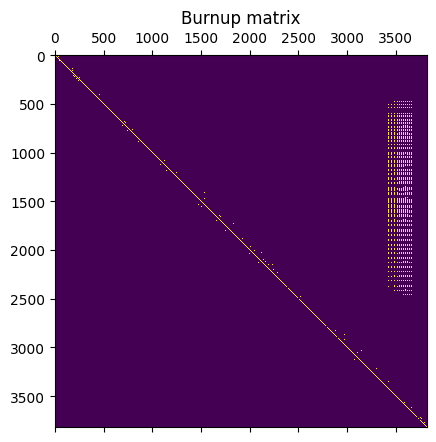

In [ ]:
plt.matshow(mat != 0)
plt.title("Burnup matrix")
plt.savefig("results/final/burnup_matrix.png")

In [ ]:
mat.shape

(3822, 3822)

In [ ]:
mat = remove_zeros(mat)
lamda = np.linalg.eig(mat)[0]

In [ ]:
get_stiffness(lamda)

2.3304206619239097e+50